### Multi-objective optimization using NSGA-II for the prioritization of manual test cases in natural language

We performed two main experiments:
* **Without feature usage**: our objectives functions are *number of covered features* (maximize) and *test execution time* (minimize)
* **With feature usage**: our objectives functions are *number of covered highly-used game features* (maximize) and *test execution time* (minimize)

In [1]:
import re
import os
import sys  
import math
import time
import pandas as pd
import numpy as np
from pathlib import Path
from statistics import mean, median
from scipy import stats
from scipy.stats import mannwhitneyu
from cliffs_delta import cliffs_delta
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MinMaxScaler
from pymoo.optimize import minimize
from pymoo.problems.functional import FunctionalProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.core.problem import Problem
from pymoo.core.population import Population
from pymoo.core.callback import Callback
from pymoo.core.termination import Termination
from matplotlib import cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [2]:
# import modules (py scripts) with needed functions and classes
sys.path.insert(0, '/utils')
sys.path.insert(0, '/optimization')

from utils import utils
from optimization import optimization

#### Load data: test cases with test labels (covered game features) and execution time

In [ ]:
test_cases_complete = utils.load_data()

In [ ]:
# Extract information from test cases
[feature_coverage_test_suite, execution_time_test_suite, mapping_test_key_test_suite,
 feature_test_id_relation, total_execution_time_test_suite, number_test_cases] = utils.get_test_data_info(test_cases_complete)

In [ ]:
features_full_suite = []

for key,value in feature_coverage_test_suite.items():
    for elem in value:
        if elem not in features_full_suite:
            features_full_suite.append(elem)

num_features_full_suite = len(features_full_suite)
print("There are {num} features being covered in test cases".format(num=num_features_full_suite))

In [ ]:
# Average number of features tested in each test case
num_feat_tested = []

for testcase in feature_coverage_test_suite:
    num_feat_tested.append(len(feature_coverage_test_suite[testcase]))
    
print("There are {count} features in each test case, on average.".format(count=mean(num_feat_tested)))
print("There is a median {count} features in each test case.".format(count=median(num_feat_tested)))

#### Get feature usage and basic usage stats

In [ ]:
# Read feature usage data (this data was collected from Snowflake at Prodigy and saved with the pickle format)
num_uses_features = pd.read_pickle('FEATURE_USAGE_DATA_PATH')
print("Number of features: {num}".format(num=len(num_uses_features)))
num_uses_features.head()

In [ ]:
# Build mapping (from Snowflake data to testing data)
mapping_dict = utils.build_feature_mapping()

# Check features that are not in the mapping (e.g., corrupted data from game data events). Use this to check if there is corrupted usage data that needs to be fixed
utils.remove_features_mapping(mapping_dict, num_uses_features)

In [ ]:
# Sort by usage and get some basic stats
num_used_features = num_uses_features.sort_values(by='Number of uses', ascending=False)
display(num_used_features.head())

most_used_features_test_suite = num_uses_features['Feature'].to_list()
print("Number of features: {num}".format(num=len(most_used_features_test_suite)))

# Generate boxplot
px.box(num_uses_features['Number of uses'].to_list())

In [ ]:
# Get median usage and set median_num_features
feat_usage_list = num_uses_features['Number of uses'].to_list()

median_usage = median(feat_usage_list)
counter_feat = 1
cum_usage = 0
for current_usage in feat_usage_list:
    cum_usage += current_usage
    if current_usage <= median_usage:
        break
    counter_feat += 1

print("Cumulative usage up to median usage: {cum_usage}".format(cum_usage=cum_usage))

cum_median_usage_perc = cum_usage/(sum(feat_usage_list))
print("Percentage of cumulative usage up to median usage: {cum_median_usage_perc}".format(cum_median_usage_perc=cum_median_usage_perc))
print("Corresponding number of features up to median usage: {median_num_features}".format(median_num_features=counter_feat))

In [12]:
# Convert feature names from game data in Snowflake to standard names in the testing side
most_used_features_test_suite_testing_std = [mapping_dict[x] for x in most_used_features_test_suite] 

In [ ]:
# Some game data events lead to the same testing feature (i.e., there are duplicates in most_used_features_test_suite_testing_std). Below, we remove them keeping the first
most_used_features_test_suite_testing_std = list(dict.fromkeys(most_used_features_test_suite_testing_std))
print("Now there are {num} features in the set of most used features".format(num=len(most_used_features_test_suite_testing_std)))

In [17]:
# List with ranking position of the most used features
most_used_features_rank = {}
counter = 1
for feat in most_used_features_test_suite_testing_std:
    most_used_features_rank[feat] = counter
    counter += 1

In [19]:
# Get num. of times each feature is covered (i.e., number of test cases where each feature appears)
feature_counter = {}
for key,value in feature_coverage_test_suite.items():
    for feat in value:
        if feat not in feature_counter:
            feature_counter[feat] = 1
        else:
            feature_counter[feat] += 1

#### Define objective/fitness functions

In [4]:
# Compute cumulative feature coverage for a specific test execution order and feature per-feature coverage threshold
def get_cum_feature_coverage_test_suite(order, feature_counter, thresh):
    cum_feature_count = 0
    cum_feature_count_array = []
    features_covered = []
    feature_counter_order = dict.fromkeys(feature_counter.keys(),0)

    for test_case_id in order:
        features = feature_coverage_test_suite[test_case_id]

        # Update dict with counter
        for feat in features:
            feature_counter_order[feat] = feature_counter_order[feat] + 1
            
            # Check if feature meets threshold to be considered covered
            if feature_counter_order[feat] >= math.floor(feature_counter[feat]*thresh):
                if feat not in features_covered:
                    features_covered.append(feat)
                    cum_feature_count = cum_feature_count + 1

        cum_feature_count_array.append(cum_feature_count)

    # Define arrays for test case (X axis) versus cumulative feature count (Y axis)
    x = np.array([i for i in range(len(order))])
    y = cum_feature_count_array
    
    # Compute area using trapezoidal rule
    area = np.trapz(y=y, x=x)
    
    # Compute optimal area
    optimal_area = np.trapz(y=np.array([num_features_full_suite]*len(x)), x=x)

    # Normalize area
    norm_area = area/optimal_area

    return norm_area

In [3]:
# Compute cumulative execution time for a specific test execution order
def get_cum_execution_time_test_suite(order):
    cum_execution_time = 0
    cum_execution_time_array = []

    for test_case_id in order:
        exec_time = execution_time_test_suite[test_case_id]
        cum_execution_time = cum_execution_time + exec_time
        cum_execution_time_array.append(cum_execution_time)
        
    x = np.array([i for i in range(len(order))])
    y = cum_execution_time_array
    
    # Compute area using trapezoidal rule
    area = np.trapz(y=y, x=x)

    # Compute optimal area
    optimal_area = np.trapz(y=np.array([total_execution_time_test_suite]*len(x)), x=x)
    
    # Normalize area
    norm_area = area/optimal_area

    return norm_area

In [2]:
# Compute ranking similarity score for a specific test execution order using 'feature usage' as relevance for features
def get_ranking_score_full_suite(order, true_relev, scaler_ndcg):
    global most_used_features_rank
    
    list_tested_features = []
    
    for test_case_id in order:
        features = feature_coverage_test_suite_reduced[test_case_id] 
        for feat in features:
                
            if feat not in list_tested_features:
                list_tested_features.append(feat)
        
    tested_feat_relev = {}
    for feat in list_tested_features:
        # Use usage ranking to find relevance for the currently tested feature
        tested_feat_relev[feat] = most_used_features_rank[feat]

    score_relev = list(tested_feat_relev.values())
    
    # Compute NDCG
    score = ndcg_score(np.asarray([true_relev]),np.asarray([score_relev]))
    scaled_score = scaler_ndcg.transform(np.asarray(score).reshape(-1, 1))[0][0]
    return scaled_score

#### Modify NSGA-II to use T-test and mutual dominance rate as stopping criteria

In [23]:
# Using callback and custom termination criteria
class MyCallback(Callback):
    
    def __init__(self, mdr_limit) -> None:
        super().__init__()
        self.data["terminate"] = False
        self.data["index"] = 0
        self.data["last_gen_solution"] = []
        self.data["current_gen_solution"] = []
        self.data["last_gen_objectives"] = []
        self.data["current_gen_objectives"] = []
        self.data["last_gen_t_test"] = False
        self.data["current_gen_t_test"] = False
        self.data["count_last_mdr"] = 0
        self.data["count_last_t_test"] = 0
        self.data["MDR_LIMIT"] = mdr_limit
        
    def get_mutual_dom_rate(self, gen_1_obj, gen_2_obj):
        counter = 0
        found = False
        for obj_values_gen_1 in gen_1_obj:
            for obj_values_gen_2 in gen_2_obj:
                if not found:
                    if all(obj_values_gen_2[index] >= obj_values_gen_1[index] for index in range(len(obj_values_gen_2))):
                        if any(obj_values_gen_2[index] > obj_values_gen_1[index] for index in range(len(obj_values_gen_2))):
                            counter += 1
                            found = True
            found = False
            
        return counter

    def notify(self, algorithm):

        if self.data["index"] == 0:
            self.data["last_gen_solution"] = algorithm.opt
            self.data["index"] = 1
            obj_results = algorithm.opt.get("F").T
            self.data["last_gen_objectives"] = obj_results

        else:
            self.data["current_gen_solution"] = algorithm.opt
            
            # Transpose objective results and iterate through results for all objectives
            obj_results = algorithm.opt.get("F").T
            self.data["current_gen_objectives"] = obj_results

            # Compute t-test for each objective
            t_test_res_list = []
            for index in range(len(self.data["current_gen_objectives"])):
                single_obj_values_current = self.data["current_gen_objectives"][index]
                single_obj_values_last = self.data["last_gen_objectives"][index]
                t_test_res = stats.ttest_ind(single_obj_values_current, single_obj_values_last)[1] # get only p-value
                t_test_res_list.append(t_test_res)
            
            # Get mutual dominance rates
            dom_last_current = self.get_mutual_dom_rate(self.data["last_gen_objectives"].T, self.data["current_gen_objectives"].T)
            dom_current_last = self.get_mutual_dom_rate(self.data["current_gen_objectives"].T, self.data["last_gen_objectives"].T)
            mdr = (dom_last_current/len(self.data["last_gen_objectives"].T)) - (dom_current_last/len(self.data["current_gen_objectives"].T))
            
            # Check is mdr is within range and increase counter; otherwise, reset counter
            if abs(mdr) < self.data["MDR_LIMIT"]:
                self.data["count_last_mdr"] += 1
            else:
                self.data["count_last_mdr"] = 0
                
            # Check is t-test for all objectives is above 0.05 and increase counter; otherwise, reset counter
            if all(i > 0.05 for i in t_test_res_list):
                self.data["count_last_t_test"] += 1
            else:
                self.data["count_last_t_test"] = 0
                
            # Check if mdr and t-test meet criteria for 5 generations
            if (self.data["count_last_mdr"] >= 5) and (self.data["count_last_t_test"] >= 5):
                self.data["terminate"] = True

            # Update last generation
            self.data["last_gen_solution"] = self.data["current_gen_solution"]
            self.data["last_gen_objectives"] = self.data["current_gen_objectives"]
            self.data["last_gen_t_test"] = self.data["current_gen_t_test"]
            self.data["last_gen_mdr"] = mdr


class MyTermination(Termination):

    def __init__(self) -> None:
        super().__init__()
        
    def terminate(self):
        self.force_termination = True
   
    def update(self, algorithm):
        """
        Provide the termination criterion a current status of the algorithm to update the perc.
        Parameters
        ----------
        algorithm : object
            The algorithm object which is used to determine whether a run has terminated.
        """
        
        if my_callback.data["terminate"]:
            self.terminate()
        
        if self.force_termination:
            progress = 1.0
        else:
            progress = self._update(algorithm)
            assert progress >= 0.0

        self.perc = progress
        return self.perc
    
    def _update(self, algorithm):
        return 0.1

---

#### Experiment 1 (without feature usage) - execute optimization 50 times

In [ ]:
# Per-feature threshold of 50%
thresh = 0.50
results_50_exec_thresh_50 = pd.DataFrame(columns=['feat_cov', 'exec_time', 'approach'])
index_add = 0

# MDR 0.05
mdr_range = 0.05
results_50_exec_thresh_50_005_list = []

for index in range(50):
    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_50_005_list.append(results_temp)

    for res in results_temp.F:
        results_50_exec_thresh_50.loc[index_add] = list(res) + ['Stop_005']
        index_add += 1
        

# MDR 0.10
mdr_range = 0.10
results_50_exec_thresh_50_010_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_50_010_list.append(results_temp)

    for res in results_temp.F:
        results_50_exec_thresh_50.loc[index_add] = list(res) + ['Stop_010']
        index_add += 1
        

# MDR 0.25
mdr_range = 0.25
results_50_exec_thresh_50_025_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)

    results_50_exec_thresh_50_025_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_50.loc[index_add] = list(res) + ['Stop_025']
        index_add += 1

In [ ]:
# Per-feature threshold of 75%
thresh = 0.75
results_50_exec_thresh_75 = pd.DataFrame(columns=['feat_cov', 'exec_time', 'approach'])
index_add = 0

# MDR 0.05
mdr_range = 0.05
results_50_exec_thresh_75_005_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_75_005_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_75.loc[index_add] = list(res) + ['Stop_005']
        index_add += 1
        

# MDR 0.10
mdr_range = 0.10
results_50_exec_thresh_75_010_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_75_010_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_75.loc[index_add] = list(res) + ['Stop_010']
        index_add += 1
        

# MDR 0.25
mdr_range = 0.25
results_50_exec_thresh_75_025_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_75_025_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_75.loc[index_add] = list(res) + ['Stop_025']
        index_add += 1

In [ ]:
# Per-feature threshold of 90%
thresh = 0.90
results_50_exec_thresh_90 = pd.DataFrame(columns=['feat_cov', 'exec_time', 'approach'])
index_add = 0

# MDR 0.05
mdr_range = 0.05
results_50_exec_thresh_90_005_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_90_005_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_90.loc[index_add] = list(res) + ['Stop_005']
        index_add += 1
        

# MDR 0.10
mdr_range = 0.10
results_50_exec_thresh_90_010_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_90_010_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_90.loc[index_add] = list(res) + ['Stop_010']
        index_add += 1
        

# MDR 0.25
mdr_range = 0.25
results_50_exec_thresh_90_025_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_90_025_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_90.loc[index_add] = list(res) + ['Stop_025']
        index_add += 1

In [ ]:
# Per-feature threshold of 100%
thresh = 1
results_50_exec_thresh_100 = pd.DataFrame(columns=['feat_cov', 'exec_time', 'approach'])
index_add = 0

# MDR 0.05
mdr_range = 0.05
results_50_exec_thresh_100_005_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_100_005_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_100.loc[index_add] = list(res) + ['Stop_005']
        index_add += 1
        

# MDR 0.10
mdr_range = 0.10
results_50_exec_thresh_100_010_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_100_010_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_100.loc[index_add] = list(res) + ['Stop_010']
        index_add += 1
        

# MDR 0.25
mdr_range = 0.25
results_50_exec_thresh_100_025_list = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_cum_feature_coverage_full_suite(x, feature_counter, thresh),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_100_025_list.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_100.loc[index_add] = list(res) + ['Stop_025']
        index_add += 100

#### Experiment 2 (with feature usage) - execute optimization 50 times

In [ ]:
# Get optimal relevance (true relevance) and its inverse (worse relevance) to normalize DCG
true_relev = list(most_used_features_rank.values())
worst_relev = true_relev.copy()
worst_relev.reverse()

# Get min and max scores (NDCG) and fit scaler
scaler_ndcg = MinMaxScaler()
max_score_ndcg = ndcg_score(np.asarray([true_relev]),np.asarray([true_relev]))
min_score_ndcg = ndcg_score(np.asarray([true_relev]),np.asarray([worst_relev]))
scaler_ndcg.fit(np.asarray([min_score_ndcg, max_score_ndcg]).reshape(-1, 1))

In [ ]:
results_50_exec_thresh_50_exp_2 = pd.DataFrame(columns=['feat_usage', 'exec_time', 'approach'])
index_add = 0

# MDR 0.05
mdr_range = 0.05
results_50_exec_thresh_50_005_list_exp_2 = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_ranking_score_full_suite(x, true_relev, scaler_ndcg),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_50_005_list_exp_2.append(results_temp)

    for res in results_temp.F:
        results_50_exec_thresh_50_exp_2.loc[index_add] = list(res) + ['Stop_005']
        index_add += 1
        

# MDR 0.10
mdr_range = 0.10
results_50_exec_thresh_50_010_list_exp_2 = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_ranking_score_full_suite(x, true_relev, scaler_ndcg),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)
    
    results_50_exec_thresh_50_010_list_exp_2.append(results_temp)

    for res in results_temp.F:
        results_50_exec_thresh_50_exp_2.loc[index_add] = list(res) + ['Stop_010']
        index_add += 1
        

# MDR 0.25
mdr_range = 0.25
results_50_exec_thresh_50_025_list_exp_2 = []

for index in range(50):

    my_callback = MyCallback(mdr_range)
    my_termination = MyTermination()

    # Multiply by (-1) because we want to solve a maximization problem (by pymoo only has minimization)
    objs = [
        lambda x: (-1)*get_ranking_score_full_suite(x, true_relev, scaler_ndcg),
        lambda x: get_cum_execution_time_full_suite(x)
    ]

    n_var = index_test_case
    problem = FunctionalProblem(n_var, objs, xl=0, xu=(index_test_case-1), vtype=int)
    algorithm = NSGA2(pop_size=100,
                     sampling=PermutationRandomSampling(),
                     mutation=InversionMutation(),
                     crossover=OrderCrossover(),
                     eliminate_duplicates=True)
    # Run optimization
    results_temp = minimize(
        problem=problem,
        algorithm=algorithm,
        termination=my_termination,
        callback=my_callback)

    results_50_exec_thresh_50_025_list_exp_2.append(results_temp)
    
    for res in results_temp.F:
        results_50_exec_thresh_50_exp_2.loc[index_add] = list(res) + ['Stop_025']
        index_add += 1

#### Random-search based approach - execute optimization 50 times

In [ ]:
results_50_executions_random_50 = []
results_50_executions_random_100 = []

# Get random solution (50 and 100)
for i in range(50):
    random_50_list = []
    for j in range(50):
        generated_perm = np.random.permutation(list(range(index_test_case)))
        random_50_list.append(generated_perm)
    results_50_executions_random_50.append(random_50_list)

for i in range(50):
    random_100_list = []
    for j in range(100):
        generated_perm = np.random.permutation(list(range(index_test_case)))
        random_100_list.append(generated_perm)
    results_50_executions_random_100.append(random_100_list)

#### Functions to plot optimal results later

In [6]:
def get_cum_perc_feature_coverage(order, feature_counter, thresh):
    cum_feature_count = 0
    cum_feature_count_array = []
    features_covered = []
    
    feature_counter_order = dict.fromkeys(feature_counter.keys(),0)
    
    for test_case_id in order:
        features = feature_coverage_full_suite[test_case_id]
        # Update dict with counter
        for feat in features:
            feature_counter_order[feat] = feature_counter_order[feat] + 1

        for feat in feature_counter_order:
            if feature_counter_order[feat] >= math.floor(feature_counter[feat]*thresh):
                if feat not in features_covered:
                    features_covered.append(feat)
                    cum_feature_count = cum_feature_count + 1

        cum_feature_count_array.append(cum_feature_count)
    
    cum_feature_count_array = np.array(cum_feature_count_array)
    percent_cum_feature_count = (cum_feature_count_array/num_features_full_suite)*100
    
    return percent_cum_feature_count

In [5]:
def get_cum_perc_execution_time(order):
    cum_execution_time = 0
    cum_execution_time_array = []
    
    for test_case_id in order:
        exec_time = execution_time_full_suite[test_case_id]
        cum_execution_time = cum_execution_time + exec_time
        cum_execution_time_array.append(cum_execution_time)

    cum_execution_time_array = np.array(cum_execution_time_array)
    
    return cum_execution_time_array

#### Functions to compute metrics

In [7]:
def get_cum_perc_feature_coverage(order, feature_counter, thresh):
    cum_feature_count = 0
    cum_feature_count_array = []
    features_covered = []
    
    feature_counter_order = dict.fromkeys(feature_counter.keys(),0)
    
    for test_case_id in order:
        features = feature_coverage_full_suite[test_case_id]

        # Update dict with counter
        for feat in features:
            feature_counter_order[feat] = feature_counter_order[feat] + 1
            
            if feature_counter_order[feat] >= math.floor(feature_counter[feat]*thresh):
                if feat not in features_covered:
                    features_covered.append(feat)
                    cum_feature_count = cum_feature_count + 1

        cum_feature_count_array.append(cum_feature_count)
        
    cum_feature_count_array = np.array(cum_feature_count_array)
    percent_cum_feature_count = (cum_feature_count_array/num_features_full_suite)*100
    
    return percent_cum_feature_count

In [8]:
def get_cum_perc_execution_time(order):
    cum_execution_time = 0
    cum_execution_time_array = []
    
    for test_case_id in order:
        exec_time = execution_time_full_suite[test_case_id]
        cum_execution_time = cum_execution_time + exec_time
        cum_execution_time_array.append(cum_execution_time)

    cum_execution_time_array = np.array(cum_execution_time_array)
    
    return cum_execution_time_array

In [9]:
def get_cum_perc_most_used_feat_cov(order, feature_counter, thresh_coverage, most_used_features_test_suite_testing_std, top_k):
    cum_top_k_covered_count = 0
    cum_top_k_covered_count_array = []
    top_k_covered = []
    feature_counter_order = dict.fromkeys(feature_counter.keys(),0)
    
    top_k_len = round(len(most_used_features_test_suite_testing_std)*top_k)
    top_k_most_used = most_used_features_test_suite_testing_std[:top_k_len]
    
    for test_case_id in order:
        features = feature_coverage_test_suite[test_case_id]
        inters_features = set(features).intersection(set(top_k_most_used))
        
        for feat in inters_features:
            if feat not in top_k_covered:
                top_k_covered.append(feat)
                cum_top_k_covered_count += 1
        
        cum_top_k_covered_count_array.append(cum_top_k_covered_count)
    
    cum_top_k_covered_count_array = np.array(cum_top_k_covered_count_array)
    percent_cum_top_k_covered_count_array = (cum_top_k_covered_count_array/top_k_len)*100
    
    return percent_cum_top_k_covered_count_array

---

### Results of experiment 1 - optimization without feature usage

#### Basic stats of optimal solutions - Number of optimal solutions found

In [53]:
# MDR within 0.05
print("There are {count} solutions for MDR within 0.05 and 50% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_005_list])))
print("There are {count} solutions for MDR within 0.05 and 75% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_75_005_list])))
print("There are {count} solutions for MDR within 0.05 and 90% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_90_005_list])))
print("There are {count} solutions for MDR within 0.05 and 100% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_100_005_list])))

There are 53.0 solutions for MDR within 0.05 and 50% per-feat.cov.
There are 48.5 solutions for MDR within 0.05 and 75% per-feat.cov.
There are 60.0 solutions for MDR within 0.05 and 90% per-feat.cov.
There are 65.0 solutions for MDR within 0.05 and 100% per-feat.cov.


In [54]:
# MDR within 0.10
print("There are {count} solutions for MDR within 0.1 and 50% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_010_list])))
print("There are {count} solutions for MDR within 0.1 and 75% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_75_010_list])))
print("There are {count} solutions for MDR within 0.1 and 90% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_90_010_list])))
print("There are {count} solutions for MDR within 0.1 and 100% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_100_010_list])))

There are 34.5 solutions for MDR within 0.1 and 50% per-feat.cov.
There are 33.5 solutions for MDR within 0.1 and 75% per-feat.cov.
There are 32.0 solutions for MDR within 0.1 and 90% per-feat.cov.
There are 35.5 solutions for MDR within 0.1 and 100% per-feat.cov.


In [55]:
# MDR within 0.25
print("There are {count} solutions for MDR within 0.25 and 50% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_025_list])))
print("There are {count} solutions for MDR within 0.25 and 75% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_75_025_list])))
print("There are {count} solutions for MDR within 0.25 and 90% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_90_025_list])))
print("There are {count} solutions for MDR within 0.25 and 100% per-feat.cov.".format(count=median([len(x.opt) for x in results_50_exec_thresh_100_025_list])))

There are 17.5 solutions for MDR within 0.25 and 50% per-feat.cov.
There are 18.0 solutions for MDR within 0.25 and 75% per-feat.cov.
There are 18.5 solutions for MDR within 0.25 and 90% per-feat.cov.
There are 18.0 solutions for MDR within 0.25 and 100% per-feat.cov.


In [56]:
# Median number of optimal solutions for each per-feat.cov. threshold
print("There are {count} solutions for 50% per-feat.cov. threshold.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_50_005_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_50_010_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_50_025_list])])))

print("There are {count} solutions for 75% per-feat.cov. threshold.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_75_005_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_75_010_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_75_025_list])])))

print("There are {count} solutions for 90% per-feat.cov. threshold.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_90_005_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_90_010_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_90_025_list])])))

print("There are {count} solutions for 100% per-feat.cov. threshold.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_100_005_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_100_010_list]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_100_025_list])])))

There are 34.5 solutions for 50% per-feat.cov. threshold.
There are 33.5 solutions for 75% per-feat.cov. threshold.
There are 32.0 solutions for 90% per-feat.cov. threshold.
There are 35.5 solutions for 100% per-feat.cov. threshold.


In [895]:
# Median number of optimal solutions for each MDR range
print("There are {count} solutions for MDR within 0.25.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_50_025_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_75_025_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_90_025_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_100_025_list])])))

print("There are {count} solutions for MDR within 0.10.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_50_010_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_75_010_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_90_010_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_100_010_list])])))

print("There are {count} solutions for MDR within 0.05.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_50_005_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_75_005_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_90_005_list]),
                                                                              median([len(x.opt) for x in results_50_exec_thresh_100_005_list])])))

There are 18.0 solutions for MDR within 0.25.
There are 34.0 solutions for MDR within 0.10.
There are 56.5 solutions for MDR within 0.05.


#### Basic stats of optimal solutions - Number of fitness evaluations to find optimal solutions found

In [61]:
# MDR within 0.05
print("There were {count} fitness eval. for MDR within 0.05 and 50% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list])))
print("There were {count} fitness eval. for MDR within 0.05 and 75% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_005_list])))
print("There were {count} fitness eval. for MDR within 0.05 and 90% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_005_list])))
print("There were {count} fitness eval. for MDR within 0.05 and 100% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_005_list])))

There were 33000.0 fitness eval. for MDR within 0.05 and 50% per-feat.cov.
There were 36700.0 fitness eval. for MDR within 0.05 and 75% per-feat.cov.
There were 45000.0 fitness eval. for MDR within 0.05 and 90% per-feat.cov.
There were 39200.0 fitness eval. for MDR within 0.05 and 100% per-feat.cov.


In [62]:
# MDR within 0.10
print("There were {count} fitness eval. for MDR within 0.1 and 50% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list])))
print("There were {count} fitness eval. for MDR within 0.1 and 75% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_010_list])))
print("There were {count} fitness eval. for MDR within 0.1 and 90% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_010_list])))
print("There were {count} fitness eval. for MDR within 0.1 and 100% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_010_list])))

There were 17150.0 fitness eval. for MDR within 0.1 and 50% per-feat.cov.
There were 13750.0 fitness eval. for MDR within 0.1 and 75% per-feat.cov.
There were 15350.0 fitness eval. for MDR within 0.1 and 90% per-feat.cov.
There were 15250.0 fitness eval. for MDR within 0.1 and 100% per-feat.cov.


In [63]:
# MDR within 0.25
print("There were {count} fitness eval. for MDR within 0.25 and 50% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list])))
print("There were {count} fitness eval. for MDR within 0.25 and 75% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_025_list])))
print("There were {count} fitness eval. for MDR within 0.25 and 90% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_025_list])))
print("There were {count} fitness eval. for MDR within 0.25 and 100% per-feat.cov.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_025_list])))

There were 3700.0 fitness eval. for MDR within 0.25 and 50% per-feat.cov.
There were 3800.0 fitness eval. for MDR within 0.25 and 75% per-feat.cov.
There were 3500.0 fitness eval. for MDR within 0.25 and 90% per-feat.cov.
There were 3250.0 fitness eval. for MDR within 0.25 and 100% per-feat.cov.


In [64]:
# Median number of optimal solutions for each per-feat.cov. threshold
print("There were {count} fitness eval. for 50% per-feat.cov. threshold.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list])])))

print("There were {count} fitness eval. for 75% per-feat.cov. threshold.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_005_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_010_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_025_list])])))

print("There were {count} fitness eval. for 90% per-feat.cov. threshold.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_005_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_010_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_025_list])])))

print("There were {count} fitness eval. for 100% per-feat.cov. threshold.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_005_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_010_list]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_025_list])])))

There were 17150.0 fitness eval. for 50% per-feat.cov. threshold.
There were 13750.0 fitness eval. for 75% per-feat.cov. threshold.
There were 15350.0 fitness eval. for 90% per-feat.cov. threshold.
There were 15250.0 fitness eval. for 100% per-feat.cov. threshold.


In [896]:
# Median number of fitness evaluations for each MDR range
print("There were {count} fitness eval. for MDR within 0.25.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_025_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_025_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_025_list])])))

print("There were {count} fitness eval. for MDR within 0.10.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_010_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_010_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_010_list])])))

print("There were {count} fitness eval. for MDR within 0.05.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_75_005_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_90_005_list]),
                                                                                   median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_100_005_list])])))

There were 3600.0 fitness eval. for MDR within 0.25.
There were 15300.0 fitness eval. for MDR within 0.10.
There were 37950.0 fitness eval. for MDR within 0.05.


#### Basic stats of optimal solutions - Execution time to find optimal solutions found

In [66]:
# MDR within 0.05
print("Execution time to find solutions for MDR within 0.05 and 50% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_005_list]), 4)))
print("Execution time to find solutions for MDR within 0.05 and 75% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_75_005_list]), 4)))
print("Execution time to find solutions for MDR within 0.05 and 90% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_90_005_list]), 4)))
print("Execution time to find solutions for MDR within 0.05 and 100% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_100_005_list]), 4)))

Execution time to find solutions for MDR within 0.05 and 50% per-feat.cov. is: 86.8531 seconds
Execution time to find solutions for MDR within 0.05 and 75% per-feat.cov. is: 85.1016 seconds
Execution time to find solutions for MDR within 0.05 and 90% per-feat.cov. is: 95.4464 seconds
Execution time to find solutions for MDR within 0.05 and 100% per-feat.cov. is: 78.3439 seconds


In [67]:
# MDR within 0.10
print("Execution time to find solutions for MDR within 0.1 and 50% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_010_list]), 4)))
print("Execution time to find solutions for MDR within 0.1 and 75% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_75_010_list]), 4)))
print("Execution time to find solutions for MDR within 0.1 and 90% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_90_010_list]), 4)))
print("Execution time to find solutions for MDR within 0.1 and 100% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_100_010_list]), 4)))

Execution time to find solutions for MDR within 0.1 and 50% per-feat.cov. is: 44.6449 seconds
Execution time to find solutions for MDR within 0.1 and 75% per-feat.cov. is: 31.7567 seconds
Execution time to find solutions for MDR within 0.1 and 90% per-feat.cov. is: 32.4744 seconds
Execution time to find solutions for MDR within 0.1 and 100% per-feat.cov. is: 30.3925 seconds


In [68]:
# MDR within 0.25
print("Execution time to find solutions for MDR within 0.25 and 50% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_025_list]), 4)))
print("Execution time to find solutions for MDR within 0.25 and 75% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_75_025_list]), 4)))
print("Execution time to find solutions for MDR within 0.25 and 90% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_90_025_list]), 4)))
print("Execution time to find solutions for MDR within 0.25 and 100% per-feat.cov. is: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_100_025_list]), 4)))

Execution time to find solutions for MDR within 0.25 and 50% per-feat.cov. is: 9.5058 seconds
Execution time to find solutions for MDR within 0.25 and 75% per-feat.cov. is: 8.6875 seconds
Execution time to find solutions for MDR within 0.25 and 90% per-feat.cov. is: 7.4244 seconds
Execution time to find solutions for MDR within 0.25 and 100% per-feat.cov. is: 6.4418 seconds


In [69]:
# Median execution time for each per-feat.cov. threshold
print("Median execution time for 50% per-feat.cov. threshold: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_50_005_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_50_010_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_50_025_list])]),4)))

print("Median execution time for 75% per-feat.cov. threshold: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_75_005_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_75_010_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_75_025_list])]),4)))

print("Median execution time for 90% per-feat.cov. threshold: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_90_005_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_90_010_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_90_025_list])]),4)))

print("Median execution time for 100% per-feat.cov. threshold: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_100_005_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_100_010_list]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_100_025_list])]),4)))

Median execution time for 50% per-feat.cov. threshold: 44.6449 seconds
Median execution time for 75% per-feat.cov. threshold: 31.7567 seconds
Median execution time for 90% per-feat.cov. threshold: 32.4744 seconds
Median execution time for 100% per-feat.cov. threshold: 30.3925 seconds


In [897]:
# Median execution time for each MDR range
print("The execution time for MDR within 0.25 was: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_50_025_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_75_025_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_90_025_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_100_025_list])]), 4)))

print("The execution time for MDR within 0.10 was: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_50_010_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_75_010_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_90_010_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_100_010_list])]), 4)))

print("The execution time for MDR within 0.05 was: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_50_005_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_75_005_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_90_005_list]),
                                                                                               median([x.exec_time for x in results_50_exec_thresh_100_005_list])]), 4)))

The execution time for MDR within 0.25 was: 8.0559 seconds
The execution time for MDR within 0.10 was: 32.1155 seconds
The execution time for MDR within 0.05 was: 85.9773 seconds


#### Analysis of non-dominated solutions

In [1061]:
# Median AUC_Feat for all approaches using per-feat.cov. threshold of 50%
main_df_results_no_feat_usage = pd.DataFrame(columns=['metric', 'approach'])
index_add = 0

for run in results_50_executions_random_50:
    for res in run:
        auc = get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Random_50']
        index_add += 1
    
for run in results_50_executions_random_100:
    for res in run:
        auc = get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Random_100']
        index_add += 1
    
for run in results_50_exec_thresh_50_025_list:
    for res in run.X:
        auc = get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.25']
        index_add += 1
    
for run in results_50_exec_thresh_50_010_list:
    for res in run.X:
        auc = get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.10']
        index_add += 1
    
for run in results_50_exec_thresh_50_005_list:
    for res in run.X:
        auc = get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.05']
        index_add += 1

print("Median for Random_50: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list())))
print("Median for Random_100: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list())))
print("Median for Stop_0.25: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())))
print("Median for Stop_0.10: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())))
print("Median for Stop_0.05: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())))

Median for Random_50: 0.5800595474394601
Median for Random_100: 0.579055180627233
Median for Stop_0.25: 0.6925764192139738
Median for Stop_0.10: 0.7670424771734816
Median for Stop_0.05: 0.7958177848352521


In [114]:
# Statistical significance and effect sizes for AUC_Feat - comparing with random approaches
print("Comparison of Stop_0.25 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.05 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 approaches with random search-based approaches
p-value =  0.0
-0.9745905598243688 large
p-value =  0.0
-0.9758386388583974 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 approaches with random search-based approaches
p-value =  0.0
-0.9988268518518518 large
p-value =  0.0
-0.9988969907407408 large
----------------------------------------------------------------------------
Comparison of Stop_0.05 approaches with random search-based approaches
p-value =  0.0
-0.9999988104089219 large
p-value =  0.0
-1.0 large


In [115]:
# Statistical significance and effect sizes for AUC_Feat - pairwise comparisons
print("Comparison of Stop_0.25 with Stop_0.10")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.25 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 with Stop_0.10
p-value =  5.511473284033851e-264
-0.820670457779404 large
----------------------------------------------------------------------------
Comparison of Stop_0.25 with Stop_0.05
p-value =  0.0
-0.9486258411239742 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 with Stop_0.05
p-value =  3.556505644125722e-180
0.5095146203359493 large


In [1063]:
# Median AUC_Time for all approaches using per-feat.cov. threshold of 50%
main_df_results_no_feat_usage = pd.DataFrame(columns=['metric', 'approach'])
index_add = 0

for run in results_50_executions_random_50:
    for res in run:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Random_50']
        index_add += 1
    
for run in results_50_executions_random_100:
    for res in run:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Random_100']
        index_add += 1

for run in results_50_exec_thresh_50_025_list:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.25']
        index_add += 1
    
for run in results_50_exec_thresh_50_010_list:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.10']
        index_add += 1
    
for run in results_50_exec_thresh_50_005_list:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results_no_feat_usage.loc[index_add] = [auc, 'Stop_0.05']
        index_add += 1
        
print("Median for Random_50: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list())))
print("Median for Random_100: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list())))
print("Median for Stop_0.25: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())))
print("Median for Stop_0.10: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())))
print("Median for Stop_0.05: {median}".format(median=median(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())))

Median for Random_50: 0.49736683107112145
Median for Random_100: 0.5003035621349701
Median for Stop_0.25: 0.3824621632912298
Median for Stop_0.10: 0.3171116517117446
Median for Stop_0.05: 0.29620300629017915


In [125]:
# Statistical significance and effect sizes for AUC_Time - comparing with random approaches
print("Comparison of Stop_0.25 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.05 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 approaches with random search-based approaches
p-value =  0.0
0.9385712403951701 large
p-value =  0.0
0.9408772777167947 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 approaches with random search-based approaches
p-value =  0.0
0.9993518518518518 large
p-value =  0.0
0.9993916666666667 large
----------------------------------------------------------------------------
Comparison of Stop_0.05 approaches with random search-based approaches
p-value =  0.0
0.9999925650557621 large
p-value =  0.0
0.9999940520446097 large


In [126]:
# Statistical significance and effect sizes for AUC_Time - pairwise comparisons
print("Comparison of Stop_0.25 with Stop_0.10")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.25 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list(),
                     main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.05']['metric'].to_list(),
                      main_df_results_no_feat_usage[main_df_results_no_feat_usage['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 with Stop_0.10
p-value =  0.0
0.9380259787778997 large
----------------------------------------------------------------------------
Comparison of Stop_0.25 with Stop_0.05
p-value =  0.0
0.9866579068714065 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 with Stop_0.05
p-value =  5.239606851547553e-261
-0.6143669110560375 large


#### Scatter plots for non-dominated solutions with both objective functions

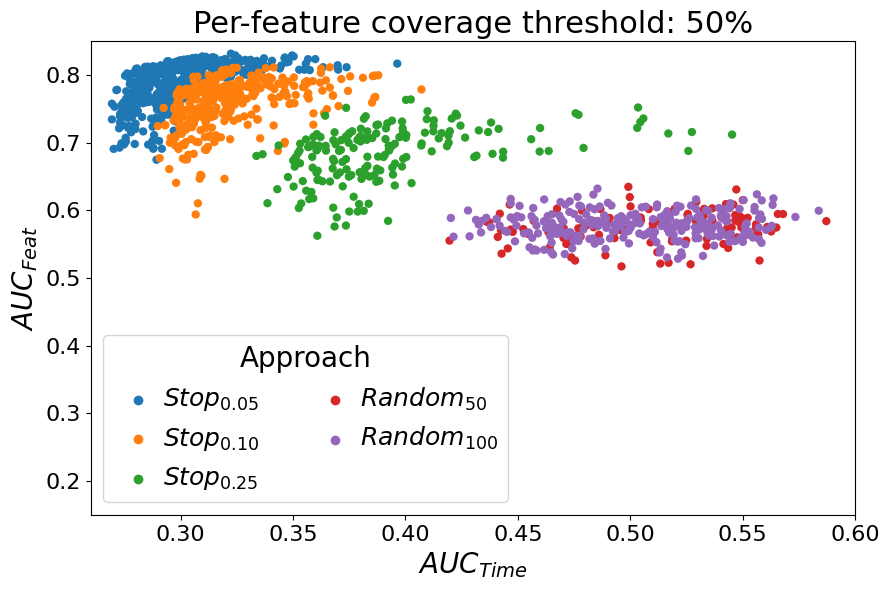

In [1064]:
# Per-feature coverage threshold of 50%

# Add results from random approaches - Execute only once
results_50_exec_thresh_50_with_random = results_50_exec_thresh_50.copy()
new_index_add = len(results_50_exec_thresh_50_with_random)

for run in results_50_executions_random_50:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_50_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_50']
        new_index_add += 1

for run in results_50_executions_random_100:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.5)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_50_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_100']
        new_index_add += 1

fig = plt.figure(figsize=(9,6))
ax = fig.subplots()

# Sample data just to generate plots with fewer data points for the paper
random_50_subset = results_50_exec_thresh_50_with_random[results_50_exec_thresh_50_with_random['approach']=='Random_50'].sample(frac=0.05, replace=False, random_state=1)
random_100_subset = results_50_exec_thresh_50_with_random[results_50_exec_thresh_50_with_random['approach']=='Random_100'].sample(frac=0.05, replace=False, random_state=1)
stop_005_subset = results_50_exec_thresh_50_with_random[results_50_exec_thresh_50_with_random['approach']=='Stop_005'].sample(frac=0.2, replace=False, random_state=1)
stop_010_subset = results_50_exec_thresh_50_with_random[results_50_exec_thresh_50_with_random['approach']=='Stop_010'].sample(frac=0.2, replace=False, random_state=1)
stop_025_subset = results_50_exec_thresh_50_with_random[results_50_exec_thresh_50_with_random['approach']=='Stop_025'].sample(frac=0.2, replace=False, random_state=9)

data_plot = pd.concat([random_50_subset, random_100_subset, stop_005_subset, stop_010_subset, stop_025_subset])
data_plot['feat_cov'] = data_plot['feat_cov'].apply(lambda x: x*-1) # multiply by (-1) for a more intuitive plot

ax = sns.scatterplot(data=data_plot, x='exec_time', y='feat_cov', hue='approach', linewidth=0, 
                    hue_order = ["Stop_005", "Stop_010", "Stop_025", "Random_50", "Random_100"])

# Plot configurations
ax.set_title("Per-feature coverage threshold: 50%", fontsize = 22)
ax.set_xlabel("$AUC_{Time}$", fontsize = 20)
ax.set_ylabel("$AUC_{Feat}$", fontsize = 20)
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.set_ylim([0.15, 0.85])
ax.set_xlim([0.26,0.6])

legend = plt.legend(title="Approach", loc=0, fontsize=18, title_fontsize=20, fancybox=True, handletextpad=0,  ncol=2)

# Set proper legend labels
legend.get_texts()[0].set_text("$Stop_{0.05}$")
legend.get_texts()[1].set_text("$Stop_{0.10}$")
legend.get_texts()[2].set_text("$Stop_{0.25}$")
legend.get_texts()[3].set_text("$Random_{50}$")
legend.get_texts()[4].set_text("$Random_{100}$")

# Save plot as PDF
fig.tight_layout()
fig.savefig("INSERT_PATH")

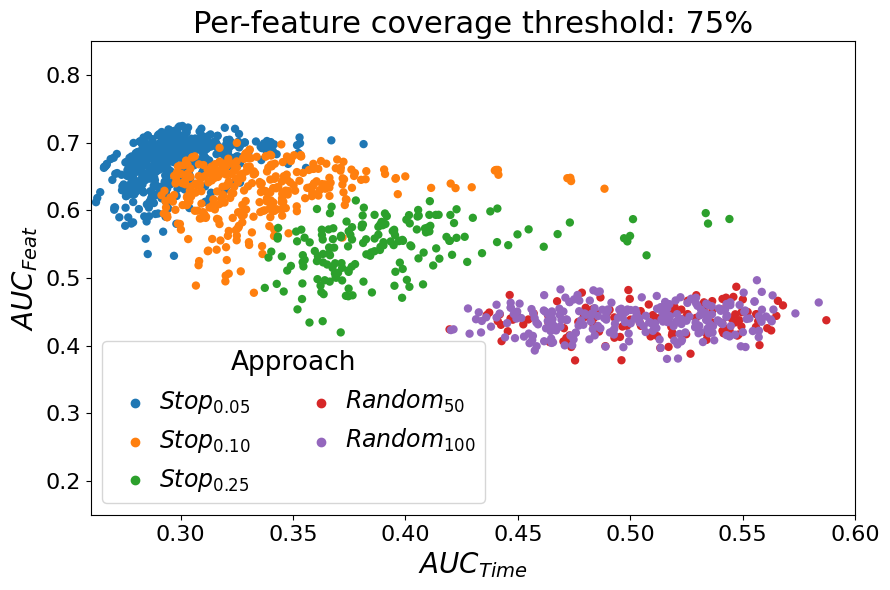

In [1065]:
# Per-feature coverage threshold of 75%

# Add results from random approaches - Execute only once
results_50_exec_thresh_75_with_random = results_50_exec_thresh_75.copy()
new_index_add = len(results_50_exec_thresh_75_with_random)

for run in results_50_executions_random_50:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.75)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_75_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_50']
        new_index_add += 1

for run in results_50_executions_random_100:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.75)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_75_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_100']
        new_index_add += 1

fig = plt.figure(figsize=(9,6))
ax = fig.subplots()

# Sample data just to generate plots with fewer data points for the paper
random_50_subset = results_50_exec_thresh_75_with_random[results_50_exec_thresh_75_with_random['approach']=='Random_50'].sample(frac=0.05, replace=False, random_state=1)
random_100_subset = results_50_exec_thresh_75_with_random[results_50_exec_thresh_75_with_random['approach']=='Random_100'].sample(frac=0.05, replace=False, random_state=1)
stop_005_subset = results_50_exec_thresh_75_with_random[results_50_exec_thresh_75_with_random['approach']=='Stop_005'].sample(frac=0.2, replace=False, random_state=1)
stop_010_subset = results_50_exec_thresh_75_with_random[results_50_exec_thresh_75_with_random['approach']=='Stop_010'].sample(frac=0.2, replace=False, random_state=1)
stop_025_subset = results_50_exec_thresh_75_with_random[results_50_exec_thresh_75_with_random['approach']=='Stop_025'].sample(frac=0.2, replace=False, random_state=9)

data_plot = pd.concat([random_50_subset, random_100_subset, stop_005_subset, stop_010_subset, stop_025_subset])
data_plot['feat_cov'] = data_plot['feat_cov'].apply(lambda x: x*-1) # multiply by (-1) for a more intuitive plot

ax = sns.scatterplot(data=data_plot, x='exec_time', y='feat_cov', hue='approach', linewidth=0, 
                    hue_order = ["Stop_005", "Stop_010", "Stop_025", "Random_50", "Random_100"])

# Plot configurations
ax.set_title("Per-feature coverage threshold: 75%", fontsize = 22)
ax.set_xlabel("$AUC_{Time}$", fontsize = 20)
ax.set_ylabel("$AUC_{Feat}$", fontsize = 20)
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.set_ylim([0.15, 0.85])
ax.set_xlim([0.26,0.6])

legend = plt.legend(title="Approach", loc=0, fontsize=17, title_fontsize=19, fancybox=True, handletextpad=0, ncol=2)

# Set proper legend labels
legend.get_texts()[0].set_text("$Stop_{0.05}$")
legend.get_texts()[1].set_text("$Stop_{0.10}$")
legend.get_texts()[2].set_text("$Stop_{0.25}$")
legend.get_texts()[3].set_text("$Random_{50}$")
legend.get_texts()[4].set_text("$Random_{100}$")

# Save plot as PDF
fig.tight_layout()
fig.savefig("INSERT_PATH")

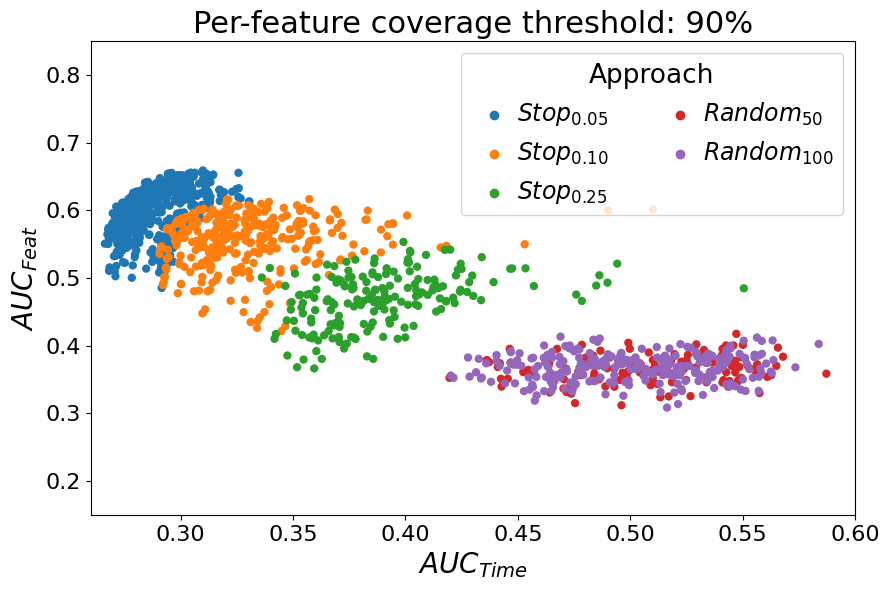

In [1067]:
# Per-feature coverage threshold of 90%

# Add results from random approaches - Execute only once
results_50_exec_thresh_90_with_random = results_50_exec_thresh_90.copy()
new_index_add = len(results_50_exec_thresh_90_with_random)

for run in results_50_executions_random_50:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.9)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_90_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_50']
        new_index_add += 1

for run in results_50_executions_random_100:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 0.9)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_90_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_100']
        new_index_add += 1

fig = plt.figure(figsize=(9,6))
ax = fig.subplots()

# Sample data just to generate plots with fewer data points for the paper
random_50_subset = results_50_exec_thresh_90_with_random[results_50_exec_thresh_90_with_random['approach']=='Random_50'].sample(frac=0.05, replace=False, random_state=1)
random_100_subset = results_50_exec_thresh_90_with_random[results_50_exec_thresh_90_with_random['approach']=='Random_100'].sample(frac=0.05, replace=False, random_state=1)
stop_005_subset = results_50_exec_thresh_90_with_random[results_50_exec_thresh_90_with_random['approach']=='Stop_005'].sample(frac=0.2, replace=False, random_state=1)
stop_010_subset = results_50_exec_thresh_90_with_random[results_50_exec_thresh_90_with_random['approach']=='Stop_010'].sample(frac=0.2, replace=False, random_state=1)
stop_025_subset = results_50_exec_thresh_90_with_random[results_50_exec_thresh_90_with_random['approach']=='Stop_025'].sample(frac=0.2, replace=False, random_state=9)

data_plot = pd.concat([random_50_subset, random_100_subset, stop_005_subset, stop_010_subset, stop_025_subset])
data_plot['feat_cov'] = data_plot['feat_cov'].apply(lambda x: x*-1) # multiply by (-1) for a more intuitive plot

ax = sns.scatterplot(data=data_plot, x='exec_time', y='feat_cov', hue='approach', linewidth=0, 
                    hue_order = ["Stop_005", "Stop_010", "Stop_025", "Random_50", "Random_100"])

# Plot configurations
ax.set_title("Per-feature coverage threshold: 90%", fontsize = 22)
ax.set_xlabel("$AUC_{Time}$", fontsize = 20)
ax.set_ylabel("$AUC_{Feat}$", fontsize = 20)
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.set_ylim([0.15, 0.85])
ax.set_xlim([0.26,0.6])

legend = plt.legend(title="Approach", loc=0, fontsize=17, title_fontsize=19, fancybox=True, handletextpad=0, ncol=2)

# Set proper legend labels
legend.get_texts()[0].set_text("$Stop_{0.05}$")
legend.get_texts()[1].set_text("$Stop_{0.10}$")
legend.get_texts()[2].set_text("$Stop_{0.25}$")
legend.get_texts()[3].set_text("$Random_{50}$")
legend.get_texts()[4].set_text("$Random_{100}$")

# Save plot as PDF
fig.tight_layout()
fig.savefig("INSERT_PATH")

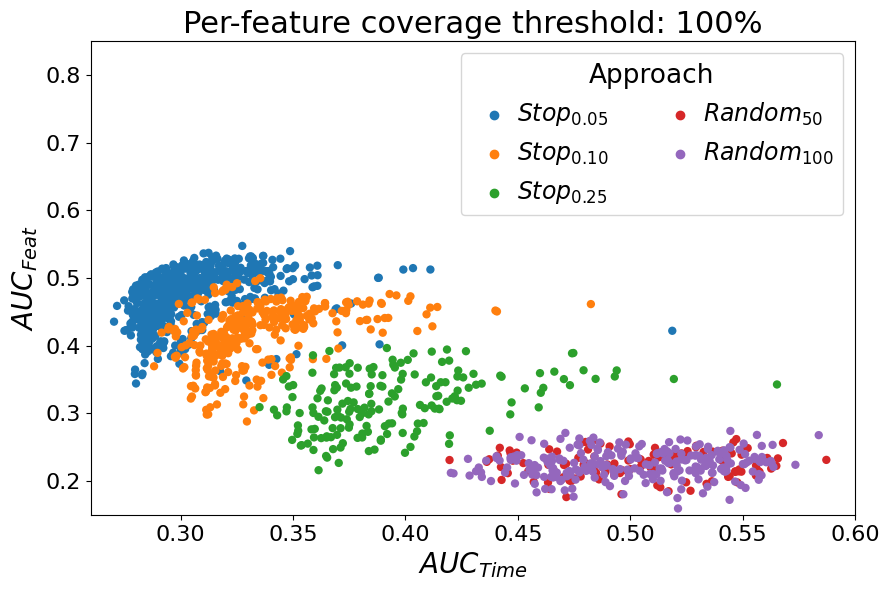

In [1068]:
# Per-feature coverage threshold of 100%

# Add results from random approaches - Execute only once
results_50_exec_thresh_100_with_random = results_50_exec_thresh_100.copy()
new_index_add = len(results_50_exec_thresh_100_with_random)

for run in results_50_executions_random_50:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 1)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_100_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_50']
        new_index_add += 1

for run in results_50_executions_random_100:
    for res in run:
        auc_feat = (-1)*get_cum_feature_coverage_full_suite(res, feature_counter, 1)
        auc_time = get_cum_execution_time_full_suite(res)
        results_50_exec_thresh_100_with_random.loc[new_index_add] = [auc_feat, auc_time, 'Random_100']
        new_index_add += 1

fig = plt.figure(figsize=(9,6))
ax = fig.subplots()

# Sample data just to generate plots with fewer data points for the paper
random_50_subset = results_50_exec_thresh_100_with_random[results_50_exec_thresh_100_with_random['approach']=='Random_50'].sample(frac=0.05, replace=False, random_state=1)
random_100_subset = results_50_exec_thresh_100_with_random[results_50_exec_thresh_100_with_random['approach']=='Random_100'].sample(frac=0.05, replace=False, random_state=1)
stop_005_subset = results_50_exec_thresh_100_with_random[results_50_exec_thresh_100_with_random['approach']=='Stop_005'].sample(frac=0.2, replace=False, random_state=1)
stop_010_subset = results_50_exec_thresh_100_with_random[results_50_exec_thresh_100_with_random['approach']=='Stop_010'].sample(frac=0.2, replace=False, random_state=1)
stop_025_subset = results_50_exec_thresh_100_with_random[results_50_exec_thresh_100_with_random['approach']=='Stop_025'].sample(frac=0.2, replace=False, random_state=9)

data_plot = pd.concat([random_50_subset, random_100_subset, stop_005_subset, stop_010_subset, stop_025_subset])
data_plot['feat_cov'] = data_plot['feat_cov'].apply(lambda x: x*-1) # multiply by (-1) for a more intuitive plot

ax = sns.scatterplot(data=data_plot, x='exec_time', y='feat_cov', hue='approach', linewidth=0, 
                    hue_order = ["Stop_005", "Stop_010", "Stop_025", "Random_50", "Random_100"])

# Plot configurations
ax.set_title("Per-feature coverage threshold: 100%", fontsize = 22)
ax.set_xlabel("$AUC_{Time}$", fontsize = 20)
ax.set_ylabel("$AUC_{Feat}$", fontsize = 20)
ax.tick_params(axis="y", labelsize=16)
ax.tick_params(axis="x", labelsize=16)
ax.set_ylim([0.15, 0.85])
ax.set_xlim([0.26,0.6])

legend = plt.legend(title="Approach", loc=0, fontsize=17, title_fontsize=19, fancybox=True, handletextpad=0, ncol=2)

# Set proper legend labels
legend.get_texts()[0].set_text("$Stop_{0.05}$")
legend.get_texts()[1].set_text("$Stop_{0.10}$")
legend.get_texts()[2].set_text("$Stop_{0.25}$")
legend.get_texts()[3].set_text("$Random_{50}$")
legend.get_texts()[4].set_text("$Random_{100}$")

# Save plot as PDF
fig.tight_layout()
fig.savefig("INSERT_PATH")

### Results of experiment 2 - optimization with feature usage
In this experiment, the per-feature coverage threshold does not matter since we do not use feature coverage as an objective function

#### Basic stats of optimal solutions - Number of optimal solutions found

In [ ]:
# MDR within 0.05
print("There are {count} solutions for MDR within 0.05.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_005_list_exp_2])))

In [ ]:
# MDR within 0.10
print("There are {count} solutions for MDR within 0.1.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_010_list_exp_2])))

In [ ]:
# MDR within 0.25
print("There are {count} solutions for MDR within 0.25.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_025_list_exp_2])))

In [ ]:
# Median number of optimal solutions
print("There are {count} solutions for.".format(count=median([median([len(x.opt) for x in results_50_exec_thresh_50_005_list_exp_2]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_50_010_list_exp_2]),
                                                                                          median([len(x.opt) for x in results_50_exec_thresh_50_025_list_exp_2])])))

In [903]:
# Median number of optimal solutions for each MDR range
print("There are {count} solutions for MDR within 0.25.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_025_list_exp_2])))
print("There are {count} solutions for MDR within 0.10.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_010_list_exp_2])))
print("There are {count} solutions for MDR within 0.05.".format(count=median([len(x.opt) for x in results_50_exec_thresh_50_005_list_exp_2])))

There are 18.0 solutions for MDR within 0.25.
There are 29.0 solutions for MDR within 0.10.
There are 42.5 solutions for MDR within 0.05.


#### Basic stats of optimal solutions - Number of fitness evaluations to find optimal solutions found

In [ ]:
# MDR within 0.05
print("There were {count} fitness eval. for MDR within 0.05.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list_exp_2])))

In [ ]:
# MDR within 0.10
print("There were {count} fitness eval. for MDR within 0.1.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list_exp_2])))

In [ ]:
# MDR within 0.25
print("There were {count} fitness eval. for MDR within 0.25.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list_exp_2])))

In [ ]:
# Median number of optimal solutions for each per-feat.cov. threshold
print("There were {count} fitness evaluations.".format(count=median([median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list_exp_2]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list_exp_2]),
                                                                                               median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list_exp_2])])))

In [906]:
# Median number of fitness evaluations for each MDR range
print("There were {count} fitness eval. for MDR within 0.25.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_025_list_exp_2])))
print("There were {count} fitness eval. for MDR within 0.10.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_010_list_exp_2])))
print("There were {count} fitness eval. for MDR within 0.05.".format(count=median([x.algorithm.evaluator.n_eval for x in results_50_exec_thresh_50_005_list_exp_2])))

There were 3650.0 fitness eval. for MDR within 0.25.
There were 12800.0 fitness eval. for MDR within 0.10.
There were 47850.0 fitness eval. for MDR within 0.05.


#### Basic stats of optimal solutions - Execution time to find optimal solutions found

In [ ]:
# MDR within 0.05
print("Execution time to find solutions for MDR within 0.05: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_005_list_exp_2]), 4)))

In [ ]:
# MDR within 0.10
print("Execution time to find solutions for MDR within 0.1: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_010_list_exp_2]), 4)))

In [ ]:
# MDR within 0.25
print("Execution time to find solutions for MDR within 0.25: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_025_list_exp_2]), 4)))

In [ ]:
# Median execution time for each per-feat.cov. threshold
print("Median execution time: {count} seconds".format(count=round(median([median([x.exec_time for x in results_50_exec_thresh_50_005_list_exp_2]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_50_010_list_exp_2]),
                                                                                                          median([x.exec_time for x in results_50_exec_thresh_50_025_list_exp_2])]),4)))

In [909]:
# Median execution time for each MDR range
print("The execution time for MDR within 0.25 was: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_025_list_exp_2]), 4)))
print("The execution time for MDR within 0.10 was: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_010_list_exp_2]), 4)))
print("The execution time for MDR within 0.05 was: {count} seconds".format(count=round(median([x.exec_time for x in results_50_exec_thresh_50_005_list_exp_2]), 4)))

The execution time for MDR within 0.25 was: 7.4718 seconds
The execution time for MDR within 0.10 was: 26.3659 seconds
The execution time for MDR within 0.05 was: 100.1574 seconds


#### Analysis of non-dominated solutions

In [918]:
# Median featRankSim (NDCG) for all approaches
main_df_results = pd.DataFrame(columns=['metric', 'approach'])
index_add = 0

for run in results_50_executions_random_50:
    for res in run:
        score = get_ranking_score_full_suite(res, true_relev, scaler_ndcg)
        main_df_results.loc[index_add] = [score, 'Random_50']
        index_add += 1
    
for run in results_50_executions_random_100:
    for res in run:
        score = get_ranking_score_full_suite(res, true_relev, scaler_ndcg)
        main_df_results.loc[index_add] = [score, 'Random_100']
        index_add += 1

for run in results_50_exec_thresh_50_025_list_exp_2:
    for res in run.X:
        score = get_ranking_score_full_suite(res, true_relev, scaler_ndcg)
        main_df_results.loc[index_add] = [score, 'Stop_0.25']
        index_add += 1
    
for run in results_50_exec_thresh_50_010_list_exp_2:
    for res in run.X:
        score = get_ranking_score_full_suite(res, true_relev, scaler_ndcg)
        main_df_results.loc[index_add] = [score, 'Stop_0.10']
        index_add += 1
        
for run in results_50_exec_thresh_50_005_list_exp_2:
    for res in run.X:
        score = get_ranking_score_full_suite(res, true_relev, scaler_ndcg)
        main_df_results.loc[index_add] = [score, 'Stop_0.05']
        index_add += 1
        
print("Median for Random_50: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list())))
print("Median for Random_100: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list())))
print("Median for Stop_0.25: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())))
print("Median for Stop_0.10: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())))
print("Median for Stop_0.05: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())))

Median for Random_50: 0.560719941324656
Median for Random_100: 0.5581853920878921
Median for Stop_0.25: 0.8186577657110399
Median for Stop_0.10: 0.9040060638991223
Median for Stop_0.05: 0.961292981788993


In [919]:
# Statistical significance and effect sizes for featRankSim - comparing with random approaches
print("Comparison of Stop_0.25 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.05 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 approaches with random search-based approaches
p-value =  0.0
-0.9443148108108108 large
p-value =  0.0
-0.9460164324324324 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 approaches with random search-based approaches
p-value =  0.0
-0.9959950103950104 large
p-value =  0.0
-0.996072072072072 large
----------------------------------------------------------------------------
Comparison of Stop_0.05 approaches with random search-based approaches
p-value =  0.0
-0.9999963014331946 large
p-value =  0.0
-0.9999966712898751 large


In [920]:
# Statistical significance and effect sizes for featRankSim - pairwise comparisons
print("Comparison of Stop_0.25 with Stop_0.10")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.25 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 with Stop_0.10
p-value =  6.828344829731363e-187
-0.7091854432394973 large
----------------------------------------------------------------------------
Comparison of Stop_0.25 with Stop_0.05
p-value =  0.0
-0.9807194712049081 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 with Stop_0.05
p-value =  0.0
0.8205791409674905 large


In [912]:
# Median AUC_Time for all approaches
main_df_results = pd.DataFrame(columns=['metric', 'approach'])
index_add = 0

for run in results_50_executions_random_50:
    for res in run:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results.loc[index_add] = [auc, 'Random_50']
        index_add += 1
    
for run in results_50_executions_random_100:
    for res in run:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results.loc[index_add] = [auc, 'Random_100']
        index_add += 1

for run in results_50_exec_thresh_50_025_list_exp_2:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results.loc[index_add] = [auc, 'Stop_0.25']
        index_add += 1
    
for run in results_50_exec_thresh_50_010_list_exp_2:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results.loc[index_add] = [auc, 'Stop_0.10']
        index_add += 1
    
for run in results_50_exec_thresh_50_005_list_exp_2:
    for res in run.X:
        auc = get_cum_execution_time_full_suite(res)
        main_df_results.loc[index_add] = [auc, 'Stop_0.05']
        index_add += 1

print("Median for Random_50: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list())))
print("Median for Random_100: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list())))
print("Median for Stop_0.25: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())))
print("Median for Stop_0.10: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())))
print("Median for Stop_0.05: {median}".format(median=median(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())))

Median for Random_50: 0.49736683107112145
Median for Random_100: 0.5003035621349701
Median for Stop_0.25: 0.3776522974581195
Median for Stop_0.10: 0.3335858466089038
Median for Stop_0.05: 0.2860033422240215


In [260]:
# Statistical significance and effect sizes for AUC_Time - comparing with random approaches
print("Comparison of Stop_0.25 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)


print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.05 approaches with random search-based approaches")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_50']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Random_100']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 approaches with random search-based approaches
p-value =  0.0
0.9773976216216216 large
p-value =  0.0
0.978729945945946 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 approaches with random search-based approaches
p-value =  0.0
0.9966586278586279 large
p-value =  0.0
0.9968135828135828 large
----------------------------------------------------------------------------
Comparison of Stop_0.05 approaches with random search-based approaches
p-value =  0.0
1.0 large
p-value =  0.0
1.0 large


In [262]:
# Statistical significance and effect sizes for AUC_Time - pairwise comparisons
print("Comparison of Stop_0.25 with Stop_0.10")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.25 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.25']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list())

print("p-value = ", p)
print(d,res)

print("----------------------------------------------------------------------------")

print("Comparison of Stop_0.10 with Stop_0.05")

U1, p = mannwhitneyu(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list(),
                     main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())
d, res = cliffs_delta(main_df_results[main_df_results['approach'] == 'Stop_0.05']['metric'].to_list(),
                      main_df_results[main_df_results['approach'] == 'Stop_0.10']['metric'].to_list())

print("p-value = ", p)
print(d,res)

Comparison of Stop_0.25 with Stop_0.10
p-value =  1.4606104897092827e-201
0.7367945908486448 large
----------------------------------------------------------------------------
Comparison of Stop_0.25 with Stop_0.05
p-value =  0.0
0.9978848196323924 large
----------------------------------------------------------------------------
Comparison of Stop_0.10 with Stop_0.05
p-value =  0.0
-0.9132957773734472 large


#### Scatter plots for non-dominated solutions with both objective functions